### Imports

In [8]:
# External modules
import numpy as np
import tensortools as tt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import load_conditioned_dataset

### Load data

In [4]:
fpath = '/Users/tlemaire/Documents/data/usnm/conditioned/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_nointercept/submap_0<-1_9->10every100/main/line3/20191112_mouse12_region1.h5'
logger.info(f'loading data from {os.path.basename(fpath)}...')
xtimeseries, popagg_timeseries, output_info_table, ROI_masks = load_conditioned_dataset(fpath)

 2024/03/16 15:44:18: loading data from 20191112_mouse12_region1.h5...
 2024/03/16 15:44:18: loading experiment info table...
 2024/03/16 15:44:18: loading conditioned timeseries data...
 2024/03/16 15:44:18: loading conditioned population-average timeseries data...
 2024/03/16 15:44:18: loading ROI masks...
 2024/03/16 15:44:18: data successfully loaded


### Extract array from data 

In [55]:
logger.info(f'data dimensions: {describe_dataframe_index(xtimeseries)}')
arr = mux_series_to_array(xtimeseries[Label.ZSCORE])

 2024/03/16 17:23:58: data dimensions: 424 ROIs x 15 runs x 16 trials x 100 frames


### Fit CP tensor decomposition

In [61]:
# Fit an ensemble of models, 4 random replicates / optimization runs per model rank
ensemble = tt.Ensemble(fit_method='ncp_hals')
ensemble.fit(arr, ranks=range(1, 30), replicates=4)

Rank-1 models:  min obj, 0.95;  max obj, 0.95;  time to fit, 0.7s


Rank-2 models:  min obj, 0.94;  max obj, 0.94;  time to fit, 11.4s


Rank-3 models:  min obj, 0.93;  max obj, 0.93;  time to fit, 10.6s


Rank-4 models:  min obj, 0.93;  max obj, 0.93;  time to fit, 11.8s


Rank-5 models:  min obj, 0.92;  max obj, 0.92;  time to fit, 8.5s


Rank-6 models:  min obj, 0.91;  max obj, 0.92;  time to fit, 13.6s


Rank-7 models:  min obj, 0.91;  max obj, 0.91;  time to fit, 14.5s


Rank-8 models:  min obj, 0.90;  max obj, 0.91;  time to fit, 22.0s


Rank-9 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 15.3s


Rank-10 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 21.0s


Rank-11 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 11.8s


Rank-12 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 15.8s


Rank-13 models:  min obj, 0.88;  max obj, 0.89;  time to fit, 30.2s


Rank-14 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 22.4s


Rank-15 models:  min obj, 0.88;  max obj, 0.88;  time to fit, 21.8s


Rank-16 models:  min obj, 0.87;  max obj, 0.88;  time to fit, 23.4s


Rank-17 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 27.8s


Rank-18 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 25.5s


Rank-19 models:  min obj, 0.87;  max obj, 0.87;  time to fit, 23.9s


Rank-20 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 23.2s


Rank-21 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 30.3s


Rank-22 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 22.6s


Rank-23 models:  min obj, 0.86;  max obj, 0.86;  time to fit, 24.4s


Rank-24 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 33.3s


Rank-25 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 44.2s


Rank-26 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 47.4s


Rank-27 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 40.3s


Rank-28 models:  min obj, 0.85;  max obj, 0.85;  time to fit, 51.0s


Rank-29 models:  min obj, 0.84;  max obj, 0.85;  time to fit, 52.3s


### Plot model ensemble convergence

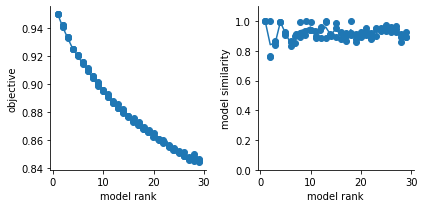

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
sns.despine(fig=fig)
tt.plot_objective(ensemble, ax=axes[0])   # plot reconstruction error as a function of num components.
tt.plot_similarity(ensemble, ax=axes[1])  # plot model similarity as a function of num components.
fig.tight_layout()

### Plot model factors

 2024/03/16 18:51:53: plotting factors for rank 1...
 2024/03/16 18:51:53: plotting factors for rank 2...
 2024/03/16 18:51:53: plotting factors for rank 3...
 2024/03/16 18:51:54: plotting factors for rank 4...


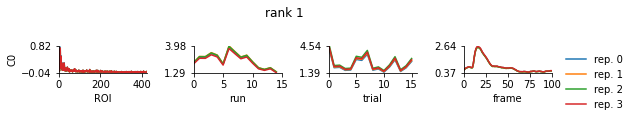

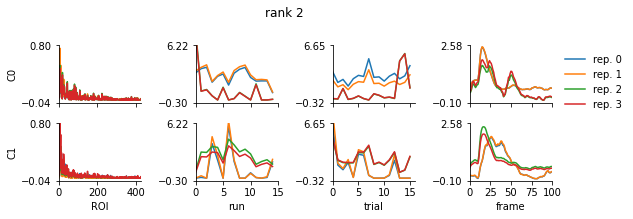

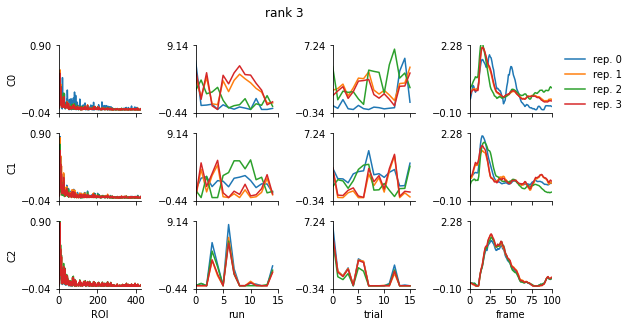

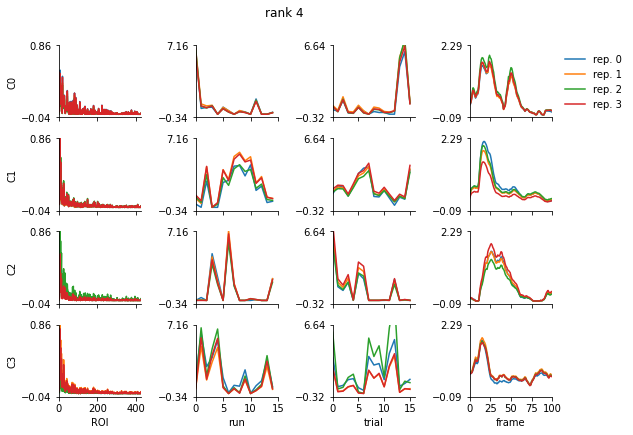

In [63]:
def plot_factors(ensemble, ncomponents=None):
    '''
    Plot low-dimensional factors for model replicates

    :param ensemble: tensortools.Ensemble
    :param ncomponents: int, rank of the model to plot. if None, plot all models
    :return: figure handle(s)
    '''
    if ncomponents is None:
        ncomponents = list(ensemble.results.keys())
    if is_iterable(ncomponents):
        if len(ncomponents) > 1:
            return [plot_factors(ensemble, ncomponents=n) for n in ncomponents]
        else:
            ncomponents = ncomponents[0]
    logger.info(f'plotting factors for rank {ncomponents}...')
    factors_list = ensemble.factors(ncomponents)
    nfactors = len(factors_list)
    fig, axes = plt.subplots(ncomponents, nfactors, figsize=(2 * nfactors, 1.5 * ncomponents))
    axes = np.atleast_2d(axes)
    fig.suptitle(f'rank {ncomponents}', y=1.)
    for i, ax in enumerate(axes[:, 0]):
        ax.set_ylabel(f'C{i}')
    for ax, lbl in zip(axes[-1, :], xtimeseries.index.names):
        ax.set_xlabel(lbl)
    for ireplicate, factors in enumerate(factors_list):
        tt.plot_factors(factors, fig=fig, line_kw=dict(label=f'rep. {ireplicate}'))
    axes[0, -1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    return fig

# Plot the low-d factors for each rank
fig = plot_factors(ensemble, ncomponents=list(range(1, 5)))